In [43]:
# %matplotlib widget
%matplotlib inline

# Introducing curiosity-driven learning

## Random exploration is not enough

In the previous tutorials, we compared the motor and goal babbling strategies on the simple arm environment. We saw that **the problem with motor babbling is that it fails to efficiently cover the sensory space in a reasonable amount of time**. 

Due to the inherent redundancy of most robotic systems (e.g. many joint configurations lead to the same hand position on a multi-dimensional arm), **random sampling** in the motor space $M$ is not appropriate if one want to learn an inverse model because the robot/agent will waste a lot of time by trying *all* the motor configurations, whereas only a subset is generally useful to cover the reachable sensory space uniformly. 

In contrast, in the **goal babbling** strategy the agent randomly samples goals in the sensory space, then tries to reach them using the current knowledge in its *sensorimotor model*. Although the agent will be poor at reaching these goals at the beginning, due to the poor quality of its sensorimotor model, it will on average cover the sensory space much more efficiently than in motor babbling, hence learning an inverse model more efficiently.

Well, random goal babbling outperforms random motor babbling in highly redundant sensorimotor systems. But there is still a couple of problems. To figure out what these problems can be, let's analyze random goal babbling in more details.

#### Terminology

- [Motor babbling](https://en.wikipedia.org/wiki/Motor_babbling) 
> Motor babbling is a process of repeatedly performing a random motor command for a short duration. It is similar to the vocal babbling of infants, where the brain learns the relation between vocal muscle activities and the resulting sounds. 

- [Inverse modeling](https://kailaix.github.io/ADCMESlides/ADCME.pdf) 
> Inverse modeling identifies a certain set of parameters or functions with which the outputs of the forward analysis matches the desired result or measurement. This is entropy - I have an expected effect my sensorymotor is such that I move my arm and my hands like this my expected action is a grasp. 

## Goal babbling with high sensory ranges

As already done in the previous tutorial, we will study an experiment with a a high-dimensional arm environment, a random goal babbling interest model, and a nearest neighbor sensorimotor model. But this time we will use another `simple_arm` configuration, called `high_dim_high_s_range`, which is the same as the `high_dimensiona`' configuration used previously, except that the sensory space ranges are doubled:

In [44]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np


from explauto.environment import environments
env_cls, env_configs, _ = environments['simple_arm']
print("'high_dimensional' configuration sensory bounds:")
print('s_mins = {} ; s_maxs = {}'.format(env_configs['high_dimensional']['s_mins'], env_configs['high_dimensional']['s_maxs']))
print("'high_dim_high_s_range' configuration sensory bounds:")
print('s_mins = {} ; s_maxs = {}'.format(env_configs['high_dim_high_s_range']['s_mins'], env_configs['high_dim_high_s_range']['s_maxs']))

'high_dimensional' configuration sensory bounds:
s_mins = [-1. -1.] ; s_maxs = [1. 1.]
'high_dim_high_s_range' configuration sensory bounds:
s_mins = [-2. -2.] ; s_maxs = [2. 2.]


We see that, whereas the 'high_dimensional' configuration specify sensory bounds are at the edges of the sensory space, the 'high_dim_high_s_range' has larger ones (between -2 and 2 on both hand coordinates).

We will use this 'high_dim_high_s_range' configuration to reflect the fact that in the framework of Developmental Robotics, there is no reason to provide the reachable sensory space ranges directly to the agent (to make a child analogy, an infant probably does not now at birth that he is unable to reach hand positions at more than a few dozen of centimeters from its shoulder.) Instead the agent should discover these bounds by its own interaction with the environment.

Let's see how random goal babbling performs with high sensory ranges. As usual, create the experiment:

In [45]:
from explauto.experiment import Experiment, make_settings

s = make_settings(environment='simple_arm', environment_config = 'high_dim_high_s_range',
                  babbling_mode='goal', 
                  interest_model='random',
                  sensorimotor_model='nearest_neighbor')

expe = Experiment.from_settings(s)

Set the evaluation time steps:

In [46]:
expe.evaluate_at([100, 200, 400, 1000], s.default_testcases)

and run the experiment:

In [47]:
expe.run()

Now we plot the randomly chosen goals and reached hand positions (in red and blue respectively):

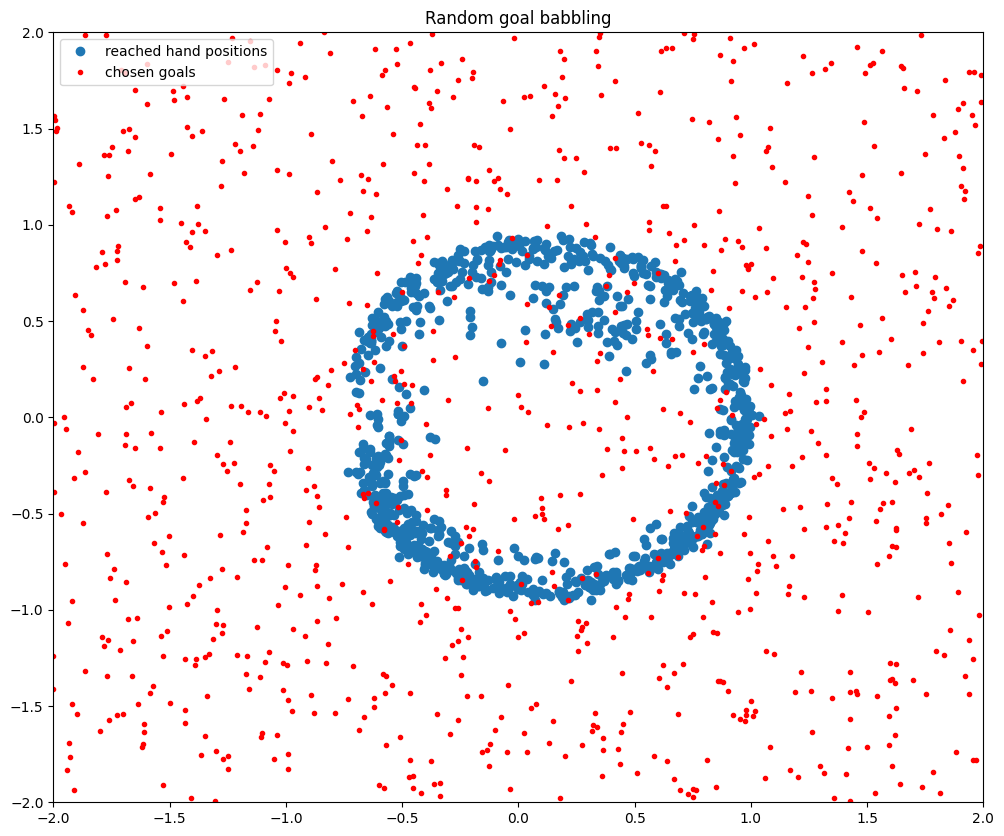

In [48]:
# plt.figure()
plt.rcParams['figure.figsize'] = (12.0, 10.0)
ax = plt.axes()
plt.title(('Random goal babbling'))
expe.log.scatter_plot(ax, (('sensori', [0, 1]),))
expe.log.scatter_plot(ax, (('choice', [0, 1]),), marker='.', color='red')
plt.legend(['reached hand positions', 'chosen goals'])

We observe that:
* The goals, which are sampled uniformly in the sensory space, can be very far from the actually reachable hand positions. This is due to the high sensory space ranges we use here (between -2 and 2 on each coordinate). A huge part of the chosen goals are therefore outside of the reachable space. 
* **In consequence, the agent mainly reaches hand positions at the boundaries of the reachable space, because it rarely set goals inside the reachable area.**

To solve this problem, we introduce curiosity-driven exploration based on the maximization of the learning progress as another possible *interest model*.

## Addition of Curiosity: The *discretized progress* and *Tree* interest models

Look at the available interest models:

In [49]:
from explauto.interest_model import interest_models
print('Available interest models: {}'.format(interest_models.keys()))

Available interest models: dict_keys(['random', 'misc_random', 'gmm_progress_beta', 'discretized_progress', 'tree'])


Until now we always used 'random', sampling uniformly in the choice space ranges (either the motor or the sensory space according to the babbling mode). We are using goal babbling in this tutoral, but this interest model also work with motor babbling.


#### *Discretized progress*

Another interest model available in Explauto is called *discretized progress*. 

This model divides the choice space into a grid and maintain an empirical measure of the learning progress in each cell. To do so, each cell keeps an history of the recent learning errors it observed. Given a choice $x\in X$ (i.e. a sample point in the choice space $X$, which corresponds to the sensory space $S$ in case of goal babbling) and an inference $y\in Y$ (the forward or inverse prediction performed by the sensorimotor model for the choice $x$, in case of goal babbling $Y=M$ and the sensorimotor model performs an inverse prediction), the associated learning error corresponds to the distance between $xy$ (the concatenation of $x$ and $y$, reordered as a vector in $M\times S$) and $ms$ (where $m$ is the executed motor command and $s$ the observed sensory consequence). (TODO: refer to the introductive section which will explain this in more details).

The learning progress is then defined as the opposite the covariance between time (relative to a particular cell) and learning error (i.e. the agent is progressing in that cell if the covariance between time and error is negative) (i.e.i.e as time increases error decreases). The *discretized progress* interest model then sample a cell according to the learning progress measure (favoring cells displaying high progresses) and finally sample a random point in that chosen cell.


#### *Tree*

**If the number of sensori dimensions is large (>2), the discretization described before won't be feasible as the number of regions is exponential in the number of dimensions.**

An idea (e.g. described in [SAGG-RIAC](http://www.pyoudeyer.com/ActiveGoalExploration-RAS-2013.pdf)), is to split a region of the sensori domain in sub-regions only when needed: when the number of points in that region become greater than a given constant (100 point per region in these simulations). Based on the [kd-tree](http://en.wikipedia.org/wiki/K-d_tree) algorithms, our implementation allows different rules to split a region. 

In the paper above was suggested to define a good split of the region $r$ in 2 sub-regions $r_1$ and $r_2$ as a split that maximizes $card(r_1)*card(r_2)*progress(r_1)*progress(r_2)$, where $card(r_i)$ is the number of points in the sub-region $i$, and $progress(r_i)$ is the absolute derivative of the competence on the points of the sub-region $r_i$.

We define here the competence on a goal point $g$ where the observed sensori consequence is $s$, as  $~e^{-power\times||g-s||}$, with $~power=10~$ in our simulations.

As the empirical progress is measured in each region of the tree, the model can then choose a new goal to try to reach,
in order to maximize the expected future progress.

A possibility is to sample a point in the region with max progress (the greedy approach), but the model might then never discover interesting regions that had an under-estimated progress. 

A better way is to sample in a random region sometimes (epsilon-greedy approach), or to sample in a region with a probability weighted by the progress, and give the weights to a softmax function with a temperature parameter $T$ that allows to adjust exploration vs exploitation ($T=1$ in our simulations):

$P_{r_i} = \frac{e^{\frac{progress(r_i)\times volume(r_i)}{T}}}{\sum_j e^{\frac{progress(r_j)\times volume(r_j)}{T}}}$

We also weight the probabilities with the volumes of the regions to ensure the continuity of the probability of a point being chosen in a region before and after its split.

*Comparisons*

So let's compare those new interest models with the random one we used before. First we create an ExperimentPool to compare random and progress based exploration in goal babbling, using the same environment as above:

In [50]:
from explauto.experiment import ExperimentPool
xps = ExperimentPool.from_settings_product(environments=[('simple_arm', 'high_dim_high_s_range')],
                                           babblings=['goal'],
                                           interest_models=[('random', 'default'), ('discretized_progress', 'default'), ('tree', 'default')],
                                           sensorimotor_models=[('nearest_neighbor', 'default')],
                                           evaluate_at=[200, 300, 500, 1000, 2000, 3000, 5000],
                                           same_testcases=True)

Run it:

In [51]:
logs = xps.run()

simple_arm
pendulum
npendulum
simple_arm
pendulum
npendulum
simple_arm
pendulum
npendulum


And compare the learning curves:

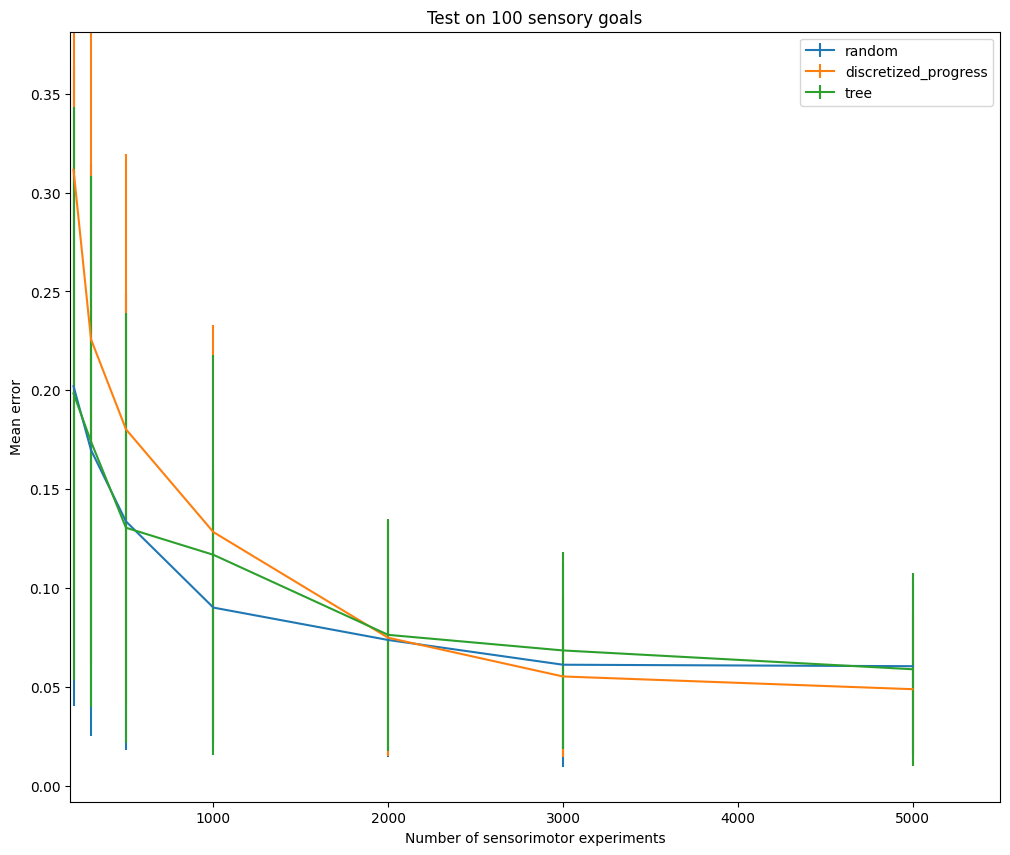

In [52]:
# plt.figure()
ax = plt.axes()

for log in xps.logs:
    log.plot_learning_curve(ax)
    
plt.legend([s.interest_model for s in xps.settings])

It seems that the Tree interest model gives better learning results, but more simulations and more test points would be necesary to see if the results are statistically significant.

We can display an animation progressively showing the reached hand positions at regular time steps of the simulation, by running the below.

Note: if you're only visualizing this notebook on nbviewer.ipython.org, you won't be able to see the animation (you will only see the end of the simulation below). To see it, you need to [install Explauto](http://flowersteam.github.io/explauto/installation.html) as well as a recent version of [Ipython Notebook](http://ipython.org/notebook.html).

In [53]:
from matplotlib.pyplot import get_current_fig_manager
import asyncio

In [54]:
# use with %matplotlib widget
# animations does't work with inline plotting, hence:
fig = plt.figure()
# plt.rcParams['figure.figsize'] = (21.0, 7.0)
# plt.ion()

async def update():
    # mng = get_current_fig_manager()
    # mng.resize(*mng.window.maxsize())
    last_t = 0
    for t in np.linspace(100, xps.logs[0].eval_at[-1], 5):
        t = int(t)
        for i, (config, log) in enumerate(zip(xps.settings, xps.logs)):
            ax = plt.subplot(1, 3, i+1)
            log.scatter_plot(ax, (('choice', [0, 1]),), t=range(t), marker='.', color='red')
            log.scatter_plot(ax, (('sensori', [0, 1]),), t=range(t), color='blue')
            log.scatter_plot(ax, (('testcases', [0, 1]),), color='green')
            plt.title(config.interest_model + ' ' + config.babbling_mode)
        # plt.draw()
        fig.canvas.draw()
        last_t = t
        await asyncio.sleep(0.1)
loop = asyncio.get_event_loop()
loop.create_task(update())
# plt.draw()


<Task pending name='Task-10' coro=<update() running at /var/folders/c4/11kj_p253ss6gs_9552l6lg80000gn/T/ipykernel_93801/2692715689.py:6>>

<Figure size 1200x1000 with 0 Axes>

In [66]:
from IPython import display
import time

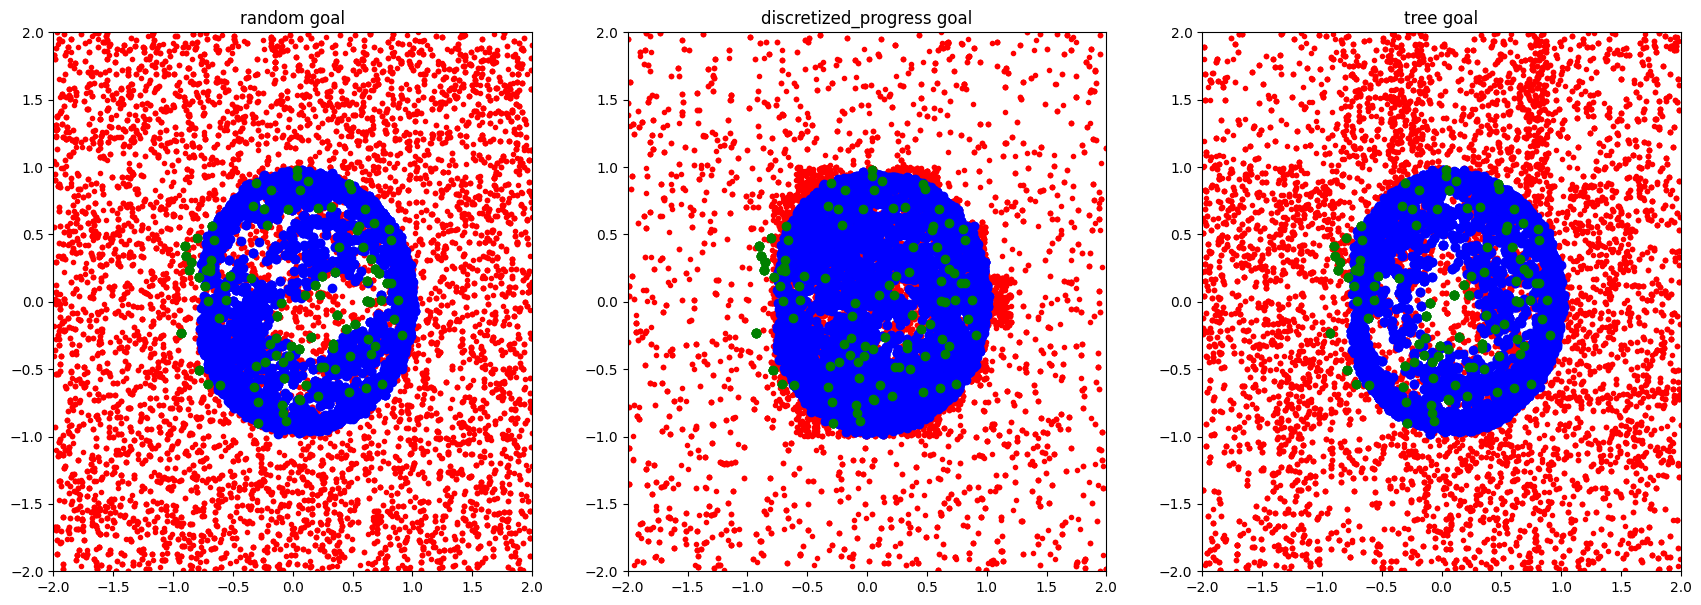

In [71]:
# animations does't work with inline plotting, hence:
# fig = plt.figure()
plt.figure()
plt.rcParams['figure.figsize'] = (21.0, 7.0)
# plt.ion()
plt.show()
# mng = get_current_fig_manager()
# mng.resize(*mng.window.maxsize())
last_t = 0
for t in np.linspace(100, xps.logs[0].eval_at[-1], 5):
    t = int(t)
    for i, (config, log) in enumerate(zip(xps.settings, xps.logs)):
        ax = plt.subplot(1, 3, i+1)
        log.scatter_plot(ax, (('choice', [0, 1]),), t=range(t), marker='.', color='red')
        log.scatter_plot(ax, (('sensori', [0, 1]),), t=range(t), color='blue')
        log.scatter_plot(ax, (('testcases', [0, 1]),), color='green')
        plt.title(config.interest_model + ' ' + config.babbling_mode)
    display.display(plt.gcf())
    time.sleep(0.5)
    display.clear_output(wait =True)

    last_t = t


Color code is the following: 

-RED: chosen goals, 

-BLUE: reached hand position, 

-GREEN: points where the competence is tested.

We observe that, whereas the *random* strategy sample points in the entire sensory space, the *discretized_progress* and *Tree* interest model (right panel) behaves smarter. By choosing goals maximizing the learning progress, those strategy focuses more on the reachable aera (reached points are more uniformly distributed in the reachable area), and favors regions which were not explored before. This exploration is therefore an *active* strategy, where goals are chosen autonomously and adaptively in order to improve the quality of the sensorimotor model.

Explauto also allows plotting heat maps by using the density_plot method. The fancy animation below shows reached hand positions by white dots as well as chosen goals on a slicing time window using a heat map (here again, if you are on ipython.notebook.com you should only see the final image of the animation).

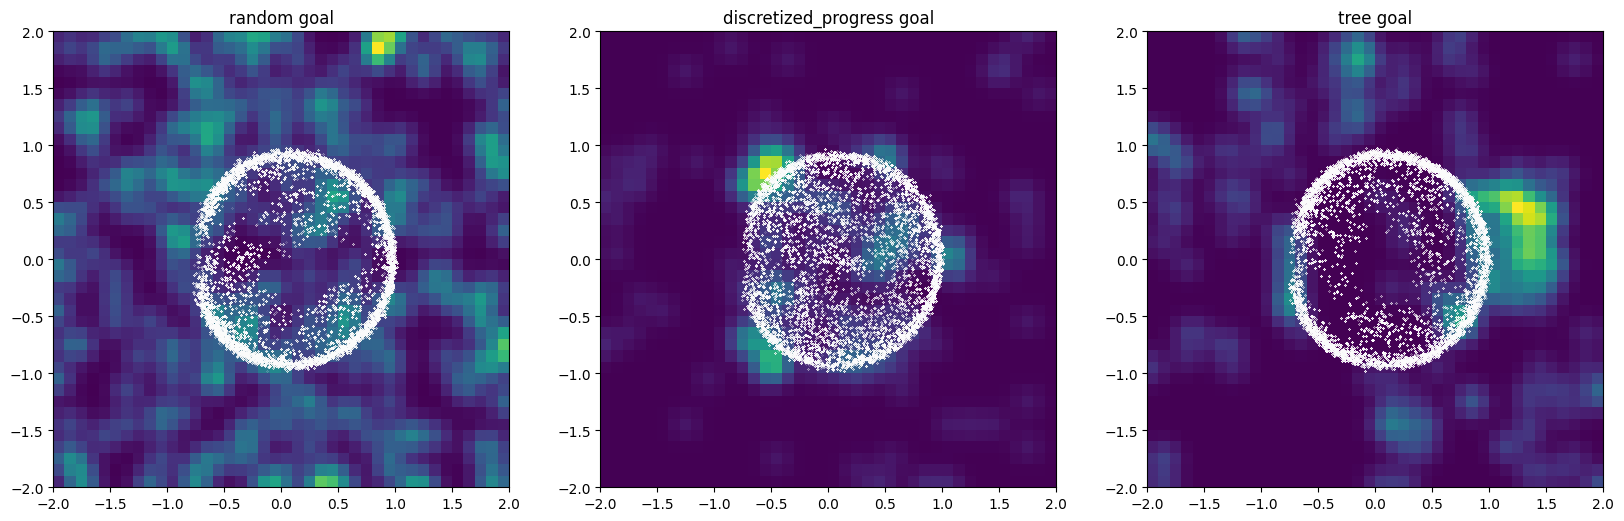

In [75]:
plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.clf()
last_t = 0
#mng = get_current_fig_manager()
#mng.resize(*mng.window.maxsize())
for t in np.linspace(100, xps.logs[0].eval_at[-1], 20):
    t = int(t)
    for i, (config, log) in enumerate(zip(xps.settings, xps.logs)):
        ax = plt.subplot(1, 3, i+1)
        log.scatter_plot(ax, (('sensori', [0, 1]),), range(0, t), marker='.', markersize=0.3, color = 'white')
        log.density_plot(ax, (('choice', [0, 1]),), range(last_t, t), width_x=1, width_y=1)
        plt.title(config.interest_model + ' ' + config.babbling_mode)
    # plt.draw()
    display.display(plt.gcf())
    time.sleep(0.5)
    display.clear_output(wait =True)
    last_t = t

After the experiment, we can re-construct the Tree interest model to plot it as it was at the end of the experiment:

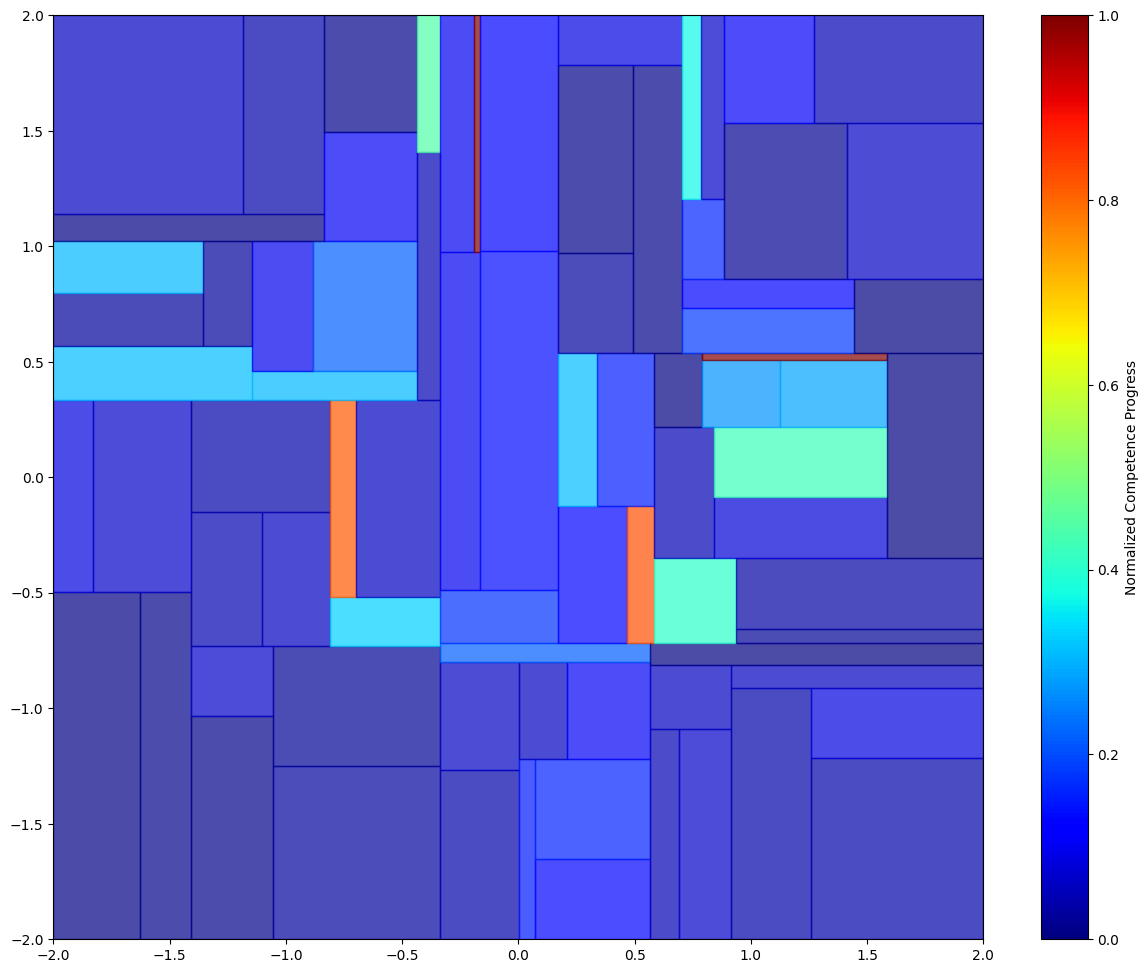

In [73]:
plt.rcParams['figure.figsize'] = (15.0, 12.0)
ax = plt.axes()

from explauto.interest_model.tree import InterestTree, interest_models

# We pick goals and reached points
data_g = np.array(xps.logs[2].logs['choice']) # goals
data_s = np.array(xps.logs[2].logs['sensori']) # reached
n = len(data_g)

xy = np.zeros((xps.logs[2].conf.ndims,))
ms = np.zeros((xps.logs[2].conf.ndims,))

# Exploratory dimensions
expl_dims = xps.logs[2].conf.s_dims

# We create an empty interest tree
interest_tree = InterestTree(xps.logs[2].conf, xps.logs[2].conf.s_dims, **interest_models['tree'][1]['default'])

# We add points one by one
for i in range(n):
    xy[expl_dims] = data_g[i]
    ms[expl_dims] = data_s[i]
    interest_tree.update(xy, ms)
    
# We plot the tree representation
interest_tree.tree.plot(ax, True, True, True, interest_tree.progress(), 20)

# Plot stuff
plt.xlim((interest_tree.tree.bounds_x[0, 0], interest_tree.tree.bounds_x[1, 0]))
plt.ylim((interest_tree.tree.bounds_x[0, 1], interest_tree.tree.bounds_x[1, 1]))
import matplotlib.colorbar as cbar
cax, _ = cbar.make_axes(ax) 
cb = cbar.ColorbarBase(cax, cmap=plt.cm.jet) 
cb.set_label('Normalized Competence Progress')

The color code represents the competence progress in the region, computed as the absolute derivative of the competence on the points in the region. 
Progress is normalized so that the maximum progress is 1.